NAME :ADIL RASHEED

MANIPAL SCHOOL OF INFORMATION SCIENCES,DEPT:AIML


In [1]:
import pandas as pd
import numpy as np
import math
import os
import datetime

from scipy.spatial.distance import pdist, squareform
from scipy.fftpack import fft
from sklearn.manifold import MDS
from sklearn.neighbors import NearestNeighbors

import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.style.use('seaborn-whitegrid')
%matplotlib inline
plt.rcParams['figure.figsize'] = (6.0, 4.0) # set default size of plots
import matplotlib.pyplot as plt

In [2]:
## Read data 
df = pd.read_csv(r"C:\Users\ibner\Downloads\New folder\data.csv", sep=",", header=0)
df['time'] = pd.to_datetime(df['time'], format='%d-%m-%Y %H:%M')
df.loc[:, (df.columns != 'time')] = df.loc[:, df.columns != 'time'].apply(pd.to_numeric, errors = 'coerce')
df = df.set_index('time')
df.head()

,Cyclone_Inlet_Gas_Temp,Cyclone_Material_Temp,Cyclone_Outlet_Gas_draft,Cyclone_cone_draft,Cyclone_Gas_Outlet_Temp,Cyclone_Inlet_Draft
time,,,,,,
2017-01-01 00:00:00,867.63,910.42,-189.54,-186.04,852.13,-145.90
2017-01-01 00:05:00,879.23,918.14,-184.33,-182.10,862.53,-149.76
2017-01-01 00:10:00,875.67,924.18,-181.26,-166.47,866.06,-145.01
2017-01-01 00:15:00,875.28,923.15,-179.15,-174.83,865.85,-142.82
2017-01-01 00:20:00,891.66,934.26,-178.32,-173.72,876.06,-143.39


Text(0, 0.5, '% Missing Values')

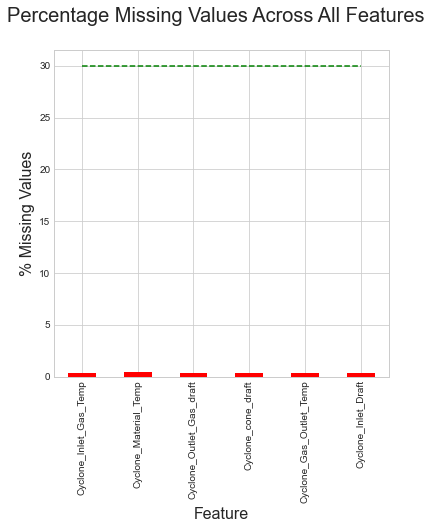

In [3]:
## Plot percentage of missing values (NaNs) for each feature
cutoff = 30
fig = plt.figure(figsize=(6, 6))
percent_missing = (df.isna().sum() / df.shape[0]) * 100
percent_missing.plot(kind = 'bar', color = cm.rainbow(np.linspace(0, 1, 2))[(percent_missing <= cutoff).values.astype(int)])
plt.plot(np.arange(df.shape[1]), np.repeat(cutoff, df.shape[1]), 'g--') 
fig.suptitle('Percentage Missing Values Across All Features', fontsize = 20)
plt.xlabel('Feature', fontsize = 16)
plt.ylabel('% Missing Values', fontsize = 16)

In [4]:
## Linear interpolation for all column
df['Cyclone_Inlet_Gas_Temp'] = df['Cyclone_Inlet_Gas_Temp'].interpolate(method = 'linear')
df["Cyclone_Material_Temp"] = df["Cyclone_Material_Temp"].interpolate(method='linear')
df["Cyclone_Outlet_Gas_draft"] = df["Cyclone_Outlet_Gas_draft"].interpolate(method='linear')
df["Cyclone_cone_draft"] = df["Cyclone_cone_draft"].interpolate(method='linear')
df["Cyclone_Gas_Outlet_Temp"] = df["Cyclone_Gas_Outlet_Temp"].interpolate(method='linear')
df["Cyclone_Inlet_Draft"] = df["Cyclone_Inlet_Draft"].interpolate(method='linear')
(df.isna().sum() / df.shape[0]) * 100

Cyclone_Inlet_Gas_Temp      0.0
Cyclone_Material_Temp       0.0
Cyclone_Outlet_Gas_draft    0.0
Cyclone_cone_draft          0.0
Cyclone_Gas_Outlet_Temp     0.0
Cyclone_Inlet_Draft         0.0
dtype: float64

In [5]:
## Extract samples for one feature such and apply FFT followed
## by calculation of pairwise distance between magnitude of FFT
## coefficients of each sample
feature_1 = df.columns[0] # "Cyclone_Inlet_Gas_Temp"
time_period = 12 # in hours
df_1 = df.groupby(pd.Grouper(freq = str(time_period)+'h')).apply(lambda x: x[feature_1].values if len(x[feature_1].values) == ((time_period*60/5)) else np.nan)
df_1 = df_1.dropna()
fftmag_1 =  np.abs(np.array([fft(x) for x in df_1.values]))
df_dist_1 = pd.DataFrame(squareform(pdist(np.abs(fftmag_1), 'euclidean')))
df_dist_1.index = df_1.index.copy()
df_dist_1.columns = df_1.index.copy()
df_dist_1.head()

time,2017-01-01 00:00:00,2017-01-01 12:00:00,2017-01-02 00:00:00,2017-01-02 12:00:00,2017-01-03 00:00:00,2017-01-03 12:00:00,2017-01-04 00:00:00,2017-01-04 12:00:00,2017-01-05 00:00:00,2017-01-05 12:00:00,...,2020-08-02 12:00:00,2020-08-03 00:00:00,2020-08-03 12:00:00,2020-08-04 00:00:00,2020-08-04 12:00:00,2020-08-05 00:00:00,2020-08-05 12:00:00,2020-08-06 00:00:00,2020-08-06 12:00:00,2020-08-07 00:00:00
time,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,0.000000,2124.522597,2843.724440,4299.948553,2773.155387,2736.049615,2745.013558,3393.427583,2410.348626,2658.177632,...,4269.414780,1354.534450,1752.365008,2207.252077,2047.346039,2929.691613,2368.960273,3404.159822,2341.763823,2413.151306
2017-01-01 12:00:00,2124.522597,0.000000,1456.820309,2918.236033,1554.762469,1504.366170,1793.677849,2087.187295,2112.027436,1704.838053,...,2800.833767,1717.083693,1466.206025,1551.922917,1637.888322,1718.671758,1513.716062,2062.361913,1552.427803,1537.734864
2017-01-02 00:00:00,2843.724440,1456.820309,0.000000,2418.048586,1152.561830,1246.241003,1770.596063,1803.243565,2388.393626,1538.179428,...,2239.223108,2399.056423,1798.600014,1719.370882,1845.479802,1500.330997,1387.504480,1402.357047,1532.016711,1492.189167
2017-01-02 12:00:00,4299.948553,2918.236033,2418.048586,0.000000,2455.480385,2395.847350,2452.354484,1681.704869,2964.104914,2472.721034,...,1647.346780,3719.547231,3290.355164,2847.438657,3087.868745,2328.141538,2609.972085,2300.984305,2476.738362,2727.335910
2017-01-03 00:00:00,2773.155387,1554.762469,1152.561830,2455.480385,0.000000,1233.675881,1897.067615,1552.147589,2468.497229,1733.896342,...,2465.366390,2233.205065,1539.722728,1334.690831,1516.119977,1196.104198,1522.628692,1493.668371,1434.322456,1374.337920


C:\Users\ibner\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  warnings.warn(


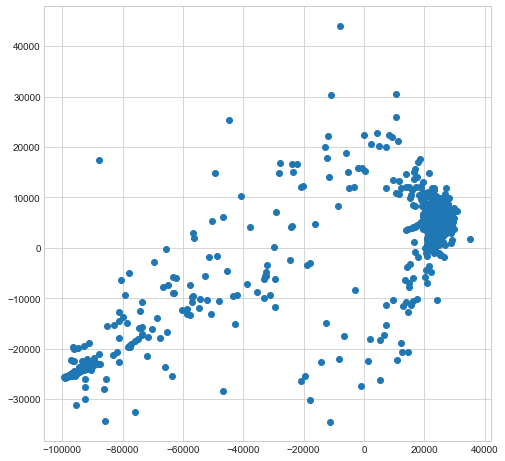

In [6]:
## Fit a 2D MDS model using the distance matrix computed above
d = 2
model_1 = MDS(n_components = d, dissimilarity = 'precomputed', random_state = 1)
mds_out_1 = model_1.fit_transform(df_dist_1)

plt.figure(figsize=(8, 8))
plt.scatter(mds_out_1[:, 0], mds_out_1[:, 1])

In [7]:
## Compute probability density of a sample being anomalous as
## k / volume of smallest hypersphere containing k NNs of that sample.
## Here k = O(M^(1/d)), where M = no. of samples and d = 2 (the reduced dimensionality)
k = np.sqrt(df_1.shape[0])
k = int(np.floor(k))
radius_1 = NearestNeighbors(n_neighbors = k+1, algorithm = 'ball_tree').fit(mds_out_1).kneighbors(mds_out_1)[0][:, -1]
f_1 = k / (np.pi * radius_1**2)
f_max_1 = np.amax(f_1)
probability_1 = 1 - (f_1 / f_max_1)

In [8]:
## Anomalous samples
np.where(probability_1 > 0.999)[0]

array([  44,   45,   49,  120,  131,  158,  159,  160,  161,  162,  163,
        164,  165,  166,  177,  188,  189,  190,  191,  192,  217,  218,
        276,  277,  278,  279,  297,  298,  299,  301,  302,  317,  318,
        325,  328,  333,  400,  401,  422,  423,  432,  502,  503,  509,
        510,  511,  512,  519,  522,  523,  524,  567,  568,  579,  580,
        581,  582,  584,  585,  587,  598,  599,  607,  661,  662,  663,
        676,  677,  680,  681,  682,  683,  684,  691,  716,  721,  759,
        791,  792,  811,  819,  820,  821,  822,  827,  836,  840,  841,
        859,  860,  909,  910,  911,  912,  913,  914,  934,  964,  965,
        966,  967,  968,  969,  971,  973,  981,  982,  985,  998,  999,
       1013, 1029, 1030, 1038, 1039, 1040, 1041, 1042, 1064, 1067, 1068,
       1069, 1070, 1071, 1083, 1084, 1097, 1098, 1099, 1105, 1106, 1107,
       1108, 1109, 1115, 1118, 1119, 1130, 1131, 1132, 1139, 1148, 1208,
       1209, 1216, 1217, 1218, 1242, 1243, 1244, 12

In [11]:
## Function for component-plotting a vector
def plotveccomp(x, xlab, ylab, title, axis = None):
  ax = axis
  component_index = range(0, len(x))
  ax.plot(component_index, x, color = 'black', marker = '') 
  ax.plot(component_index, [np.mean(x)]*len(x), linewidth = 1, linestyle = 'dashed', color ='blue') 
  ax.plot(component_index, [np.mean(x) - np.std(x)]*len(x), linewidth = 1, linestyle = 'dashed', color ='red')
  ax.plot(component_index, [np.mean(x) + np.std(x)]*len(x), linewidth = 1, linestyle = 'dashed', color ='red')
  ax.set_xlabel(xlab)
  ax.set_ylabel(ylab)
  ax.set_title(title)

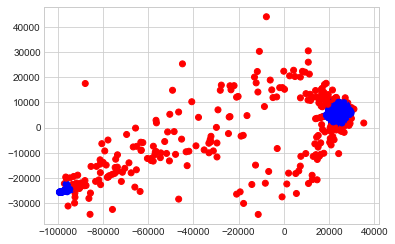

In [13]:
plt.scatter(mds_out_1[:, 0], mds_out_1[:, 1], c =  np.where(probability_1 > prob_cutoff, 'r', 'b'))

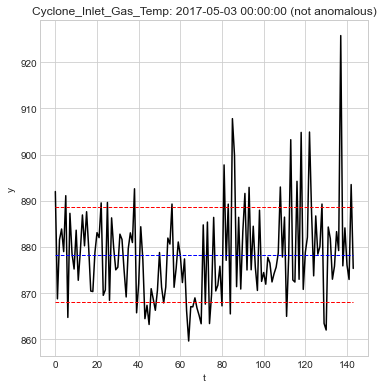

In [12]:
## Randomly pick a non-anomalous sample and plot
prob_cutoff = 0.999
j_na_1 = np.random.choice(np.where(probability_1 <= prob_cutoff )[0], 1)
fig, ax = plt.subplots(1, 1, figsize = (6,6))
fig.tight_layout(pad = 4.0)
plotveccomp(df_1.iloc[int(j_na_1)], 't', 'y', feature_1 + ': ' + str(df_1.index[j_na_1][0]) + ' (not anomalous)', ax)

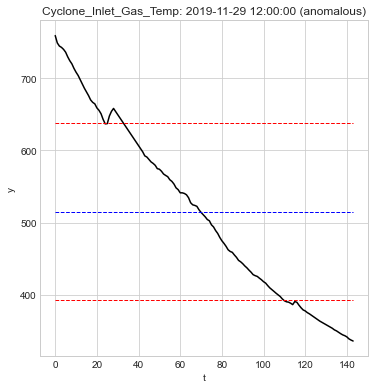

In [14]:
## Randomly pick an anomalous sample and plot
j_a_1 = np.random.choice(np.where(probability_1 > prob_cutoff)[0], 1)
fig, ax = plt.subplots(1, 1, figsize = (6,6))
fig.tight_layout(pad = 4.0)
plotveccomp(df_1.iloc[int(j_a_1)], 't', 'y', feature_1 + ': ' +  str(df_1.index[j_a_1][0]) + ' (anomalous)', ax)

# For the second feature Cyclone_Material_Temp 

In [15]:
feature_2 = df.columns[1] # "Cyclone_Inlet_Gas_Temp"
time_period = 12 # in hours
df_2 = df.groupby(pd.Grouper(freq = str(time_period)+'h')).apply(lambda x: x[feature_2].values if len(x[feature_2].values) == ((time_period*60/5)) else np.nan)
df_2 = df_2.dropna()
fftmag_2 =  np.abs(np.array([fft(x) for x in df_2.values]))
df_dist_2 = pd.DataFrame(squareform(pdist(np.abs(fftmag_2), 'euclidean')))
df_dist_2.index = df_2.index.copy()
df_dist_2.columns = df_2.index.copy()
df_dist_2.head()

time,2017-01-01 00:00:00,2017-01-01 12:00:00,2017-01-02 00:00:00,2017-01-02 12:00:00,2017-01-03 00:00:00,2017-01-03 12:00:00,2017-01-04 00:00:00,2017-01-04 12:00:00,2017-01-05 00:00:00,2017-01-05 12:00:00,...,2020-08-02 12:00:00,2020-08-03 00:00:00,2020-08-03 12:00:00,2020-08-04 00:00:00,2020-08-04 12:00:00,2020-08-05 00:00:00,2020-08-05 12:00:00,2020-08-06 00:00:00,2020-08-06 12:00:00,2020-08-07 00:00:00
time,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,0.000000,2784.932255,2083.533708,3273.233818,966.513259,951.671368,1588.924026,1567.542639,2172.495023,1367.254641,...,3884.200539,6105.671176,4477.547372,3444.611554,2968.936279,1942.081751,4153.902654,2324.961646,3604.912163,3402.043622
2017-01-01 12:00:00,2784.932255,0.000000,1240.198218,1856.691210,2602.306025,2584.539917,3700.729805,1927.090656,3959.842450,3031.037463,...,5565.062008,8483.074945,6781.329856,5858.513213,5392.477550,4166.696913,6420.908228,4453.823248,6025.019647,5726.235292
2017-01-02 00:00:00,2083.533708,1240.198218,0.000000,1929.465669,1809.623723,1791.218326,3081.048538,1528.274316,3258.431743,2475.379087,...,5138.137992,7822.501339,6123.132183,5221.130491,4717.848865,3492.052336,5748.050527,3793.335913,5344.522846,5092.894794
2017-01-02 12:00:00,3273.233818,1856.691210,1929.465669,0.000000,3145.065813,3168.240990,4367.744838,2136.520912,3558.089817,3114.015085,...,6024.139446,9073.930435,7526.337062,6475.111655,5971.225961,4680.502711,6993.064589,5148.716250,6577.041411,6431.737761
2017-01-03 00:00:00,966.513259,2602.306025,1809.623723,3145.065813,0.000000,852.866212,1788.339237,1624.875141,2293.545900,1633.613775,...,4158.477686,6251.209433,4682.249882,3694.768258,3154.738009,2262.175023,4344.062553,2524.864320,3802.208228,3658.009651


C:\Users\ibner\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  warnings.warn(


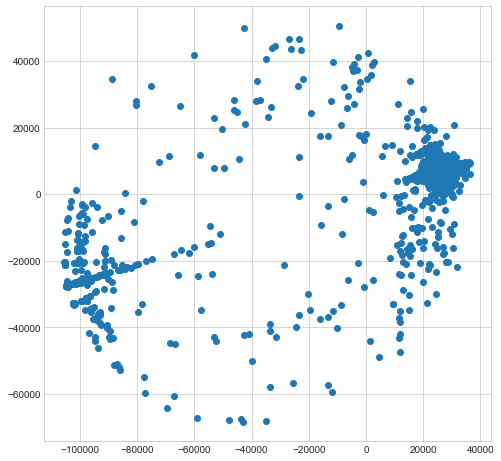

In [16]:
## Fit a 2D MDS model using the distance matrix computed above
d = 2
model_2 = MDS(n_components = d, dissimilarity = 'precomputed', random_state = 1)
mds_out_2 = model_2.fit_transform(df_dist_2)

plt.figure(figsize=(8, 8))
plt.scatter(mds_out_2[:, 0], mds_out_2[:, 1])

In [17]:
## Compute probability density of a sample being anomalous as
## k / volume of smallest hypersphere containing k NNs of that sample.
## Here k = O(M^(1/d)), where M = no. of samples and d = 2 (the reduced dimensionality)
k = np.sqrt(df_2.shape[0])
k = int(np.floor(k))
radius_2 = NearestNeighbors(n_neighbors = k+1, algorithm = 'ball_tree').fit(mds_out_2).kneighbors(mds_out_2)[0][:, -1]
f_2 = k / (np.pi * radius_2**2)
f_max_2 = np.amax(f_2)
probability_2 = 1 - (f_2 / f_max_2)

In [18]:
## Anomalous samples
np.where(probability_2 > 0.999)[0]

array([   0,    1,    2, ..., 2620, 2621, 2622], dtype=int64)

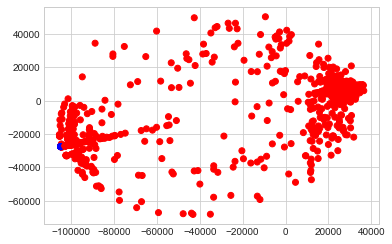

In [19]:
plt.scatter(mds_out_2[:, 0], mds_out_2[:, 1], c =  np.where(probability_2 > prob_cutoff, 'r', 'b'))

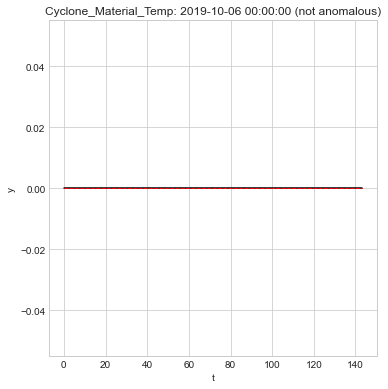

In [20]:
## Randomly pick a non-anomalous sample and plot
prob_cutoff = 0.999
j_na_2 = np.random.choice(np.where(probability_2 <= prob_cutoff )[0], 1)
fig, ax = plt.subplots(1, 1, figsize = (6,6))
fig.tight_layout(pad = 4.0)
plotveccomp(df_2.iloc[int(j_na_2)], 't', 'y', feature_2 + ': ' + str(df_2.index[j_na_2][0]) + ' (not anomalous)', ax)

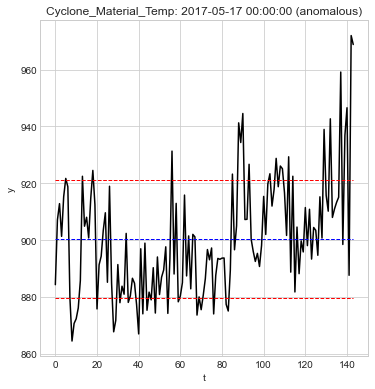

In [21]:
## Randomly pick an anomalous sample and plot
j_a_2 = np.random.choice(np.where(probability_2 > prob_cutoff)[0], 1)
fig, ax = plt.subplots(1, 1, figsize = (6,6))
fig.tight_layout(pad = 4.0)
plotveccomp(df_2.iloc[int(j_a_2)], 't', 'y', feature_2 + ': ' +  str(df_2.index[j_a_2][0]) + ' (anomalous)', ax)

# For the third feature Cyclone_Outlet_Gas_draft:

In [22]:
feature_3 = df.columns[2] # "Cyclone_Inlet_Gas_Temp"
time_period = 12 # in hours
df_3 = df.groupby(pd.Grouper(freq = str(time_period)+'h')).apply(lambda x: x[feature_3].values if len(x[feature_3].values) == ((time_period*60/5)) else np.nan)
df_3 = df_3.dropna()
fftmag_3 =  np.abs(np.array([fft(x) for x in df_3.values]))
df_dist_3 = pd.DataFrame(squareform(pdist(np.abs(fftmag_3), 'euclidean')))
df_dist_3.index = df_3.index.copy()
df_dist_3.columns = df_3.index.copy()
df_dist_3.head()

time,2017-01-01 00:00:00,2017-01-01 12:00:00,2017-01-02 00:00:00,2017-01-02 12:00:00,2017-01-03 00:00:00,2017-01-03 12:00:00,2017-01-04 00:00:00,2017-01-04 12:00:00,2017-01-05 00:00:00,2017-01-05 12:00:00,...,2020-08-02 12:00:00,2020-08-03 00:00:00,2020-08-03 12:00:00,2020-08-04 00:00:00,2020-08-04 12:00:00,2020-08-05 00:00:00,2020-08-05 12:00:00,2020-08-06 00:00:00,2020-08-06 12:00:00,2020-08-07 00:00:00
time,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,0.000000,649.949308,1306.093889,1198.162222,1051.729941,1179.986313,2244.910105,2086.814162,1491.133571,1584.648791,...,9053.539896,10663.388433,7587.155554,8157.997876,7973.026777,7428.502965,8079.522969,8248.058581,7040.730236,6851.420095
2017-01-01 12:00:00,649.949308,0.000000,812.139391,709.829305,618.791073,700.740206,2279.912501,1566.963013,998.743751,1070.561120,...,8543.896078,10147.709898,7073.976434,7661.433045,7452.168707,6906.681785,7613.879664,7745.986188,6523.362106,6327.013627
2017-01-02 00:00:00,1306.093889,812.139391,0.000000,436.534492,559.612677,606.454473,2339.633914,990.621480,519.822452,608.243865,...,7857.730695,9457.733655,6383.467427,6984.728819,6747.508920,6207.647657,6918.614302,7081.398852,5827.208163,5624.733223
2017-01-02 12:00:00,1198.162222,709.829305,436.534492,0.000000,493.380730,436.702904,2300.256963,1011.217004,532.632969,592.966824,...,7949.600247,9547.954887,6472.795017,7067.581364,6854.275685,6307.102914,7023.429249,7154.904900,5928.673897,5728.425459
2017-01-03 00:00:00,1051.729941,618.791073,559.612677,493.380730,0.000000,618.784396,2236.804354,1234.385119,703.752222,774.776019,...,8143.093789,9749.086647,6675.630749,7272.510299,7052.051350,6506.034652,7212.021017,7361.242857,6114.527669,5923.037493


C:\Users\ibner\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  warnings.warn(


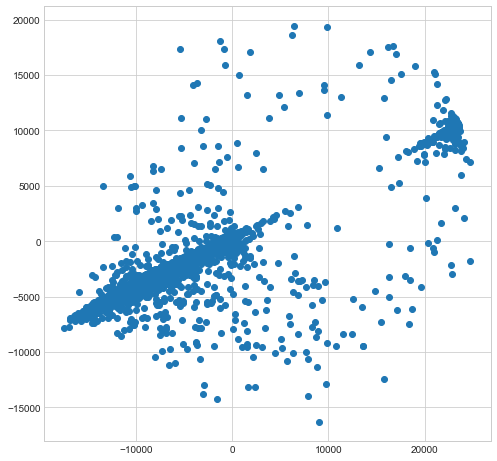

In [23]:
## Fit a 2D MDS model using the distance matrix computed above
d = 2
model_3 = MDS(n_components = d, dissimilarity = 'precomputed', random_state = 1)
mds_out_3 = model_3.fit_transform(df_dist_3)

plt.figure(figsize=(8, 8))
plt.scatter(mds_out_3[:, 0], mds_out_3[:, 1])

In [24]:
## Compute probability density of a sample being anomalous as
## k / volume of smallest hypersphere containing k NNs of that sample.
## Here k = O(M^(1/d)), where M = no. of samples and d = 2 (the reduced dimensionality)
k = np.sqrt(df_3.shape[0])
k = int(np.floor(k))
radius_3 = NearestNeighbors(n_neighbors = k+1, algorithm = 'ball_tree').fit(mds_out_3).kneighbors(mds_out_3)[0][:, -1]
f_3 = k / (np.pi * radius_3**2)
f_max_3 = np.amax(f_3)
probability_3 = 1 - (f_3 / f_max_3)

In [25]:
## Anomalous samples
np.where(probability_3 > 0.999)[0]

array([   6,   43,   44,   45,   49,   50,   51,   55,   63,  111,  114,
        120,  131,  132,  140,  158,  162,  166,  168,  175,  177,  178,
        185,  187,  188,  192,  200,  201,  214,  217,  236,  256,  257,
        269,  270,  276,  277,  278,  299,  300,  301,  302,  307,  309,
        313,  317,  318,  322,  325,  328,  333,  344,  349,  350,  352,
        353,  357,  361,  387,  400,  401,  416,  418,  422,  423,  426,
        432,  441,  462,  463,  464,  467,  473,  479,  502,  503,  509,
        511,  512,  519,  522,  523,  524,  582,  584,  585,  586,  587,
        589,  590,  591,  598,  599,  606,  607,  608,  609,  614,  620,
        639,  650,  658,  659,  660,  661,  662,  663,  664,  665,  683,
        684,  685,  686,  687,  690,  691,  692,  693,  695,  716,  717,
        720,  721,  722,  723,  724,  728,  729,  734,  742,  744,  758,
        759,  762,  763,  787,  788,  791,  792,  800,  811,  819,  822,
        823,  827,  828,  833,  836,  840,  841,  8

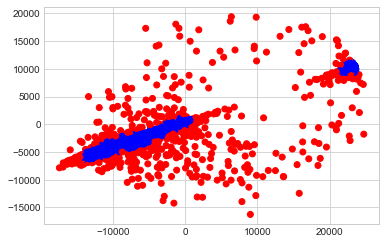

In [26]:
plt.scatter(mds_out_3[:, 0], mds_out_3[:, 1], c =  np.where(probability_3 > prob_cutoff, 'r', 'b'))

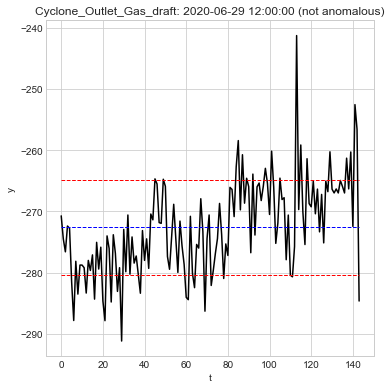

In [27]:
## Randomly pick a non-anomalous sample and plot
prob_cutoff = 0.999
j_na_3 = np.random.choice(np.where(probability_3 <= prob_cutoff )[0], 1)
fig, ax = plt.subplots(1, 1, figsize = (6,6))
fig.tight_layout(pad = 4.0)
plotveccomp(df_3.iloc[int(j_na_3)], 't', 'y', feature_3 + ': ' + str(df_3.index[j_na_3][0]) + ' (not anomalous)', ax)

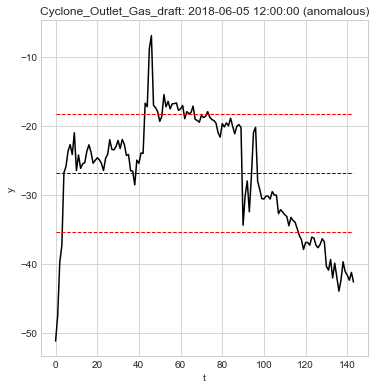

In [49]:
## Randomly pick an anomalous sample and plot
j_a_3 = np.random.choice(np.where(probability_3 > prob_cutoff)[0], 1)
fig, ax = plt.subplots(1, 1, figsize = (6,6))
fig.tight_layout(pad = 4.0)
plotveccomp(df_3.iloc[int(j_a_3)], 't', 'y', feature_3 + ': ' +  str(df_3.index[j_a_3][0]) + ' (anomalous)', ax)

# For the fourth feature Cyclone_cone_draft:

In [29]:
feature_4 = df.columns[3] # "Cyclone_Inlet_Gas_Temp"
time_period = 12 # in hours
df_4 = df.groupby(pd.Grouper(freq = str(time_period)+'h')).apply(lambda x: x[feature_4].values if len(x[feature_4].values) == ((time_period*60/5)) else np.nan)
df_4 = df_4.dropna()
fftmag_4 =  np.abs(np.array([fft(x) for x in df_4.values]))
df_dist_4 = pd.DataFrame(squareform(pdist(np.abs(fftmag_4), 'euclidean')))
df_dist_4.index = df_4.index.copy()
df_dist_4.columns = df_4.index.copy()
df_dist_4.head()

time,2017-01-01 00:00:00,2017-01-01 12:00:00,2017-01-02 00:00:00,2017-01-02 12:00:00,2017-01-03 00:00:00,2017-01-03 12:00:00,2017-01-04 00:00:00,2017-01-04 12:00:00,2017-01-05 00:00:00,2017-01-05 12:00:00,...,2020-08-02 12:00:00,2020-08-03 00:00:00,2020-08-03 12:00:00,2020-08-04 00:00:00,2020-08-04 12:00:00,2020-08-05 00:00:00,2020-08-05 12:00:00,2020-08-06 00:00:00,2020-08-06 12:00:00,2020-08-07 00:00:00
time,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,0.000000,1826.430210,4287.151164,4126.352259,2238.898913,1947.437211,1157.725209,971.001485,1380.058557,1171.558967,...,7208.898984,8018.972442,7117.896261,7584.966053,7138.663639,7659.043515,6092.300641,7298.983665,5449.648929,5541.690560
2017-01-01 12:00:00,1826.430210,0.000000,3116.600394,3778.107662,1838.458941,2537.424206,1626.500327,2282.448514,2374.082114,2088.531941,...,6588.697646,7145.989181,6740.606368,7103.440630,6758.786039,7074.468088,4879.058427,6577.467380,5026.436123,4875.173637
2017-01-02 00:00:00,4287.151164,3116.600394,0.000000,4811.817628,3635.898985,4279.291007,4104.498385,4664.236467,4635.578868,4301.856369,...,6798.012372,7057.266623,7336.342345,7459.540216,7311.354211,7151.083464,4160.267850,6669.861795,5660.876390,5278.589285
2017-01-02 12:00:00,4126.352259,3778.107662,4811.817628,0.000000,2392.034805,5558.966840,4285.124286,4213.081359,3416.006039,4711.393110,...,3210.918243,4326.253130,3132.278144,3563.874336,3142.140895,3753.154879,4042.176969,3342.255087,1507.386952,1718.985644
2017-01-03 00:00:00,2238.898913,1838.458941,3635.898985,2392.034805,0.000000,3447.873855,2317.872134,2425.792443,1963.060730,2645.689077,...,5325.321693,6044.979912,5353.894515,5762.536940,5371.145288,5803.908642,4297.158872,5347.130458,3677.270182,3627.237950


C:\Users\ibner\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  warnings.warn(


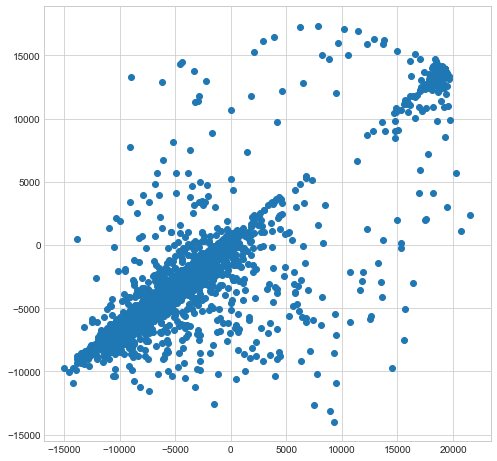

In [30]:
## Fit a 2D MDS model using the distance matrix computed above
d = 2
model_4 = MDS(n_components = d, dissimilarity = 'precomputed', random_state = 1)
mds_out_4 = model_4.fit_transform(df_dist_4)

plt.figure(figsize=(8, 8))
plt.scatter(mds_out_4[:, 0], mds_out_4[:, 1])

In [31]:
## Compute probability density of a sample being anomalous as
## k / volume of smallest hypersphere containing k NNs of that sample.
## Here k = O(M^(1/d)), where M = no. of samples and d = 2 (the reduced dimensionality)
k = np.sqrt(df_4.shape[0])
k = int(np.floor(k))
radius_4 = NearestNeighbors(n_neighbors = k+1, algorithm = 'ball_tree').fit(mds_out_4).kneighbors(mds_out_4)[0][:, -1]
f_4 = k / (np.pi * radius_4**2)
f_max_4 = np.amax(f_4)
probability_4 = 1 - (f_4 / f_max_4)

In [32]:
## Anomalous samples
np.where(probability_4 > 0.999)[0]

array([   0,    1,    2, ..., 2619, 2620, 2622], dtype=int64)

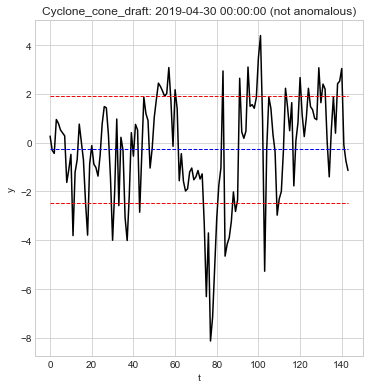

In [33]:
## Randomly pick a non-anomalous sample and plot
prob_cutoff = 0.999
j_na_4 = np.random.choice(np.where(probability_4 <= prob_cutoff )[0], 1)
fig, ax = plt.subplots(1, 1, figsize = (6,6))
fig.tight_layout(pad = 4.0)
plotveccomp(df_4.iloc[int(j_na_4)], 't', 'y', feature_4 + ': ' + str(df_4.index[j_na_4][0]) + ' (not anomalous)', ax)

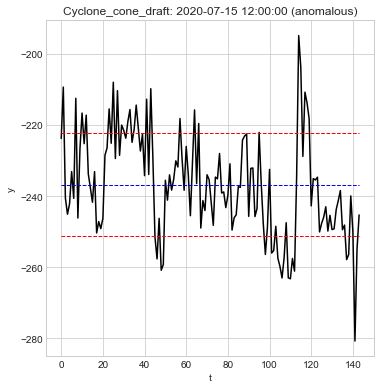

In [34]:
## Randomly pick an anomalous sample and plot
j_a_4 = np.random.choice(np.where(probability_4 > prob_cutoff)[0], 1)
fig, ax = plt.subplots(1, 1, figsize = (6,6))
fig.tight_layout(pad = 4.0)
plotveccomp(df_4.iloc[int(j_a_4)], 't', 'y', feature_4 + ': ' +  str(df_4.index[j_a_4][0]) + ' (anomalous)', ax)

# For the fifth feature Cyclone_Gas_Outlet_Temp:

In [35]:
feature_5 = df.columns[4] # "Cyclone_Inlet_Gas_Temp"
time_period = 12 # in hours
df_5 = df.groupby(pd.Grouper(freq = str(time_period)+'h')).apply(lambda x: x[feature_5].values if len(x[feature_5].values) == ((time_period*60/5)) else np.nan)
df_5 = df_5.dropna()
fftmag_5 =  np.abs(np.array([fft(x) for x in df_5.values]))
df_dist_5 = pd.DataFrame(squareform(pdist(np.abs(fftmag_5), 'euclidean')))
df_dist_5.index = df_5.index.copy()
df_dist_5.columns = df_5.index.copy()
df_dist_5.head()

time,2017-01-01 00:00:00,2017-01-01 12:00:00,2017-01-02 00:00:00,2017-01-02 12:00:00,2017-01-03 00:00:00,2017-01-03 12:00:00,2017-01-04 00:00:00,2017-01-04 12:00:00,2017-01-05 00:00:00,2017-01-05 12:00:00,...,2020-08-02 12:00:00,2020-08-03 00:00:00,2020-08-03 12:00:00,2020-08-04 00:00:00,2020-08-04 12:00:00,2020-08-05 00:00:00,2020-08-05 12:00:00,2020-08-06 00:00:00,2020-08-06 12:00:00,2020-08-07 00:00:00
time,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,0.000000,1589.595296,1362.372010,2392.345198,1842.645598,1859.816760,1941.888327,1616.303708,2329.805411,1145.391770,...,5064.587894,2063.685888,2774.291769,3218.633761,2479.276973,4062.672580,3539.205436,5051.203014,4070.722933,3741.145290
2017-01-01 12:00:00,1589.595296,0.000000,1098.157201,1895.252966,2974.009536,2945.750233,2964.995963,2278.492376,3512.275688,2057.259735,...,3957.137911,1285.815991,1885.200961,2242.542826,1676.975664,3009.129821,2592.973666,3962.187503,3091.974016,2698.199644
2017-01-02 00:00:00,1362.372010,1098.157201,0.000000,2185.556182,2599.878222,2583.798681,2629.786044,2044.541453,3213.774985,1900.456507,...,4242.223631,1481.663254,2063.760646,2523.552594,1905.293049,3346.811596,2783.235124,4186.638409,3402.503688,2979.260617
2017-01-02 12:00:00,2392.345198,1895.252966,2185.556182,0.000000,3795.686423,3828.424737,3552.867480,3375.918154,3720.333179,2587.488065,...,3510.772856,1991.247322,2431.849990,2495.001147,1970.774750,2993.548396,2530.417792,4067.271770,2728.165161,2851.032954
2017-01-03 00:00:00,1842.645598,2974.009536,2599.878222,3795.686423,0.000000,831.485848,1261.107630,1431.305013,1748.109619,1657.769289,...,6607.850293,3434.861122,4326.319287,4769.131935,3982.340256,5664.144338,5065.716476,6572.540386,5671.768440,5287.467227


C:\Users\ibner\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  warnings.warn(


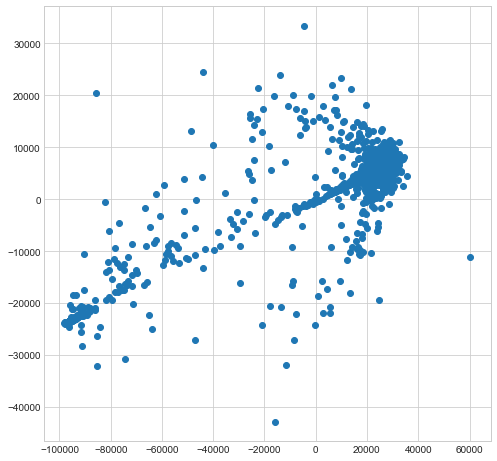

In [36]:
## Fit a 2D MDS model using the distance matrix computed above
d = 2
model_5 = MDS(n_components = d, dissimilarity = 'precomputed', random_state = 1)
mds_out_5 = model_5.fit_transform(df_dist_5)

plt.figure(figsize=(8, 8))
plt.scatter(mds_out_5[:, 0], mds_out_5[:, 1])

In [37]:
## Compute probability density of a sample being anomalous as
## k / volume of smallest hypersphere containing k NNs of that sample.
## Here k = O(M^(1/d)), where M = no. of samples and d = 2 (the reduced dimensionality)
k = np.sqrt(df_5.shape[0])
k = int(np.floor(k))
radius_5 = NearestNeighbors(n_neighbors = k+1, algorithm = 'ball_tree').fit(mds_out_5).kneighbors(mds_out_5)[0][:, -1]
f_5 = k / (np.pi * radius_5**2)
f_max_5 = np.amax(f_5)
probability_5 = 1 - (f_5 / f_max_5)

In [38]:
## Anomalous samples
np.where(probability_5 > 0.999)[0]

array([  44,   45,   49,  120,  131,  158,  159,  160,  161,  162,  163,
        164,  165,  166,  177,  188,  189,  190,  191,  192,  218,  276,
        277,  278,  279,  297,  298,  299,  301,  302,  317,  318,  325,
        328,  400,  401,  422,  423,  432,  502,  503,  509,  510,  511,
        512,  517,  519,  522,  523,  524,  567,  568,  579,  580,  581,
        582,  584,  585,  598,  599,  607,  661,  662,  663,  676,  677,
        680,  681,  682,  683,  684,  691,  716,  729,  759,  791,  792,
        811,  819,  820,  821,  822,  823,  827,  833,  835,  840,  841,
        845,  859,  860,  861,  862,  863,  864,  865,  866,  867,  868,
        869,  870,  871,  872,  873,  874,  875,  876,  877,  878,  879,
        880,  881,  882,  883,  884,  909,  910,  911,  912,  913,  914,
        923,  934,  946,  947,  948,  949,  950,  951,  952,  953,  954,
        955,  956,  957,  958,  959,  960,  961,  962,  963,  964,  965,
        966,  967,  968,  969,  971,  973,  975,  9

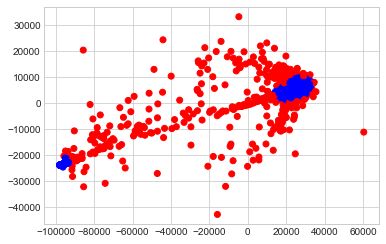

In [39]:
plt.scatter(mds_out_5[:, 0], mds_out_5[:, 1], c =  np.where(probability_5 > prob_cutoff, 'r', 'b'))

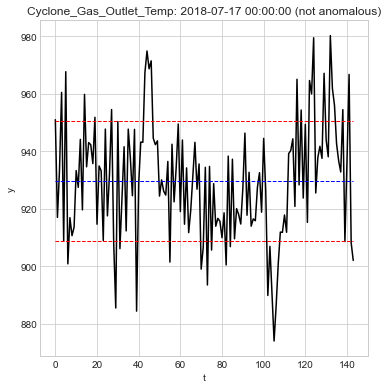

In [40]:
## Randomly pick a non-anomalous sample and plot
prob_cutoff = 0.999
j_na_5 = np.random.choice(np.where(probability_5 <= prob_cutoff )[0], 1)
fig, ax = plt.subplots(1, 1, figsize = (6,6))
fig.tight_layout(pad = 4.0)
plotveccomp(df_5.iloc[int(j_na_5)], 't', 'y', feature_5 + ': ' + str(df_5.index[j_na_5][0]) + ' (not anomalous)', ax)

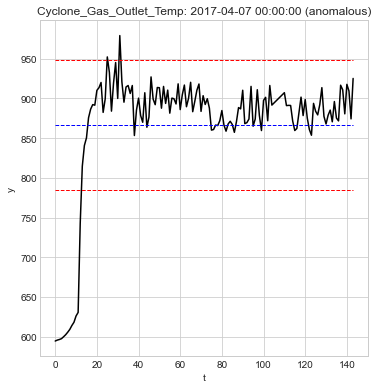

In [41]:
## Randomly pick an anomalous sample and plot
j_a_5 = np.random.choice(np.where(probability_5 > prob_cutoff)[0], 1)
fig, ax = plt.subplots(1, 1, figsize = (6,6))
fig.tight_layout(pad = 4.0)
plotveccomp(df_5.iloc[int(j_a_5)], 't', 'y', feature_5 + ': ' +  str(df_5.index[j_a_5][0]) + ' (anomalous)', ax)

# For the sixth feature Cyclone_Inlet_Draft:

In [42]:
feature_6 = df.columns[5] # "Cyclone_Inlet_Gas_Temp"
time_period = 12 # in hours
df_6 = df.groupby(pd.Grouper(freq = str(time_period)+'h')).apply(lambda x: x[feature_6].values if len(x[feature_6].values) == ((time_period*60/5)) else np.nan)
df_6 = df_6.dropna()
fftmag_6 =  np.abs(np.array([fft(x) for x in df_6.values]))
df_dist_6 = pd.DataFrame(squareform(pdist(np.abs(fftmag_6), 'euclidean')))
df_dist_6.index = df_6.index.copy()
df_dist_6.columns = df_6.index.copy()
df_dist_6.head()

time,2017-01-01 00:00:00,2017-01-01 12:00:00,2017-01-02 00:00:00,2017-01-02 12:00:00,2017-01-03 00:00:00,2017-01-03 12:00:00,2017-01-04 00:00:00,2017-01-04 12:00:00,2017-01-05 00:00:00,2017-01-05 12:00:00,...,2020-08-02 12:00:00,2020-08-03 00:00:00,2020-08-03 12:00:00,2020-08-04 00:00:00,2020-08-04 12:00:00,2020-08-05 00:00:00,2020-08-05 12:00:00,2020-08-06 00:00:00,2020-08-06 12:00:00,2020-08-07 00:00:00
time,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,0.000000,530.260809,1168.325736,944.907394,787.977588,1217.717907,2087.867545,1974.192655,1936.426304,1874.971297,...,6519.474134,8115.001196,5245.568130,5758.993581,5742.804924,5368.394326,5810.690348,5996.512516,5014.902834,4740.168595
2017-01-01 12:00:00,530.260809,0.000000,974.779710,751.651816,675.762196,896.241251,1894.710502,1740.780343,1695.982136,1585.509860,...,6221.113527,7832.249083,4958.858550,5447.181108,5472.336557,5090.477415,5538.739931,5689.519760,4729.841830,4468.429260
2017-01-02 00:00:00,1168.325736,974.779710,0.000000,585.604906,666.692168,792.827145,1958.507684,1014.924158,951.435649,929.421429,...,5489.948423,7059.770949,4210.184455,4759.658287,4678.025338,4302.904362,4803.122325,4999.964131,3966.288888,3682.964801
2017-01-02 12:00:00,944.907394,751.651816,585.604906,0.000000,527.790948,650.876179,1856.761768,1202.560384,1178.015502,1098.053000,...,5696.491644,7284.527034,4419.941381,4948.282074,4920.476678,4537.207894,5016.749029,5189.317327,4187.230047,3917.747695
2017-01-03 00:00:00,787.977588,675.762196,666.692168,527.790948,0.000000,840.360903,1936.520546,1363.331409,1331.363846,1291.347150,...,5900.276970,7485.105393,4628.774753,5166.056770,5110.033963,4728.787120,5212.084580,5402.500552,4379.573821,4111.220484


C:\Users\ibner\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  warnings.warn(


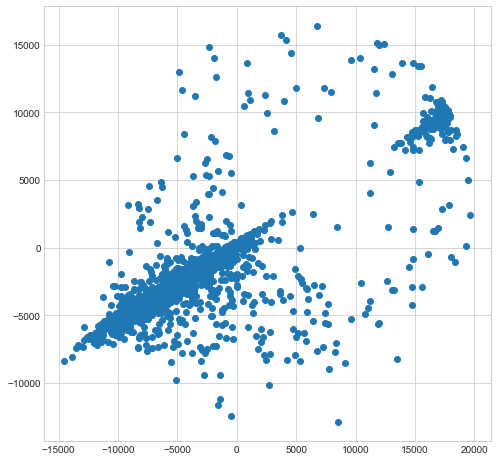

In [43]:
## Fit a 2D MDS model using the distance matrix computed above
d = 2
model_6 = MDS(n_components = d, dissimilarity = 'precomputed', random_state = 1)
mds_out_6 = model_6.fit_transform(df_dist_6)

plt.figure(figsize=(8, 8))

plt.scatter(mds_out_6[:, 0], mds_out_6[:, 1])



In [44]:
## Compute probability density of a sample being anomalous as
## k / volume of smallest hypersphere containing k NNs of that sample.
## Here k = O(M^(1/d)), where M = no. of samples and d = 2 (the reduced dimensionality)
k = np.sqrt(df_6.shape[0])
k = int(np.floor(k))
radius_6 = NearestNeighbors(n_neighbors = k+1, algorithm = 'ball_tree').fit(mds_out_6).kneighbors(mds_out_6)[0][:, -1]
f_6 = k / (np.pi * radius_6**2)
f_max_6 = np.amax(f_6)
probability_6 = 1 - (f_6 / f_max_6)

In [45]:
## Anomalous samples
np.where(probability_6 > 0.999)[0]

array([   6,   28,   29,   30,   36,   38,   43,   44,   45,   49,   50,
         51,   55,   63,   93,  111,  114,  120,  131,  132,  140,  144,
        149,  158,  159,  162,  166,  168,  175,  177,  178,  185,  187,
        188,  192,  200,  201,  213,  214,  217,  220,  223,  236,  237,
        250,  254,  256,  257,  268,  269,  270,  271,  272,  273,  274,
        275,  276,  277,  278,  299,  300,  301,  302,  303,  307,  309,
        311,  313,  317,  318,  321,  322,  323,  325,  328,  329,  333,
        344,  349,  350,  352,  357,  361,  400,  401,  416,  418,  422,
        423,  426,  432,  441,  462,  463,  464,  476,  479,  502,  503,
        509,  511,  512,  517,  519,  522,  523,  524,  581,  582,  583,
        584,  585,  587,  589,  591,  596,  598,  599,  600,  606,  607,
        608,  609,  614,  620,  634,  639,  644,  650,  658,  659,  660,
        661,  662,  663,  664,  665,  676,  683,  684,  685,  686,  687,
        690,  691,  692,  693,  695,  700,  716,  7

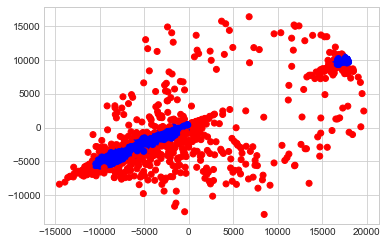

In [46]:

plt.scatter(mds_out_6[:, 0], mds_out_6[:, 1], c =  np.where(probability_6 > prob_cutoff, 'r', 'b'))

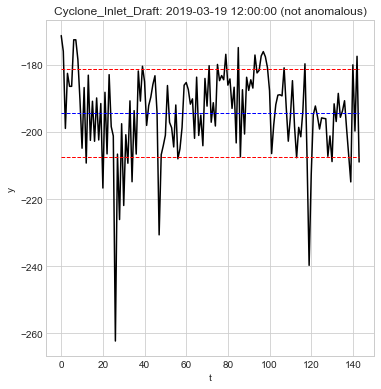

In [56]:
## Randomly pick a non-anomalous sample and plot
prob_cutoff = 0.999
j_na_6 = np.random.choice(np.where(probability_6 <= prob_cutoff )[0], 1)
fig, ax = plt.subplots(1, 1, figsize = (6,6))
fig.tight_layout(pad = 4.0)
plotveccomp(df_6.iloc[int(j_na_6)], 't', 'y', feature_6 + ': ' + str(df_6.index[j_na_6][0]) + ' (not anomalous)', ax)

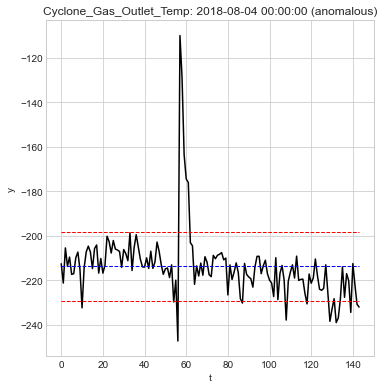

In [59]:
## Randomly pick an anomalous sample and plot
j_a_6 = np.random.choice(np.where(probability_6 > prob_cutoff)[0], 1)
fig, ax = plt.subplots(1, 1, figsize = (6,6))
fig.tight_layout(pad = 4.0)
plotveccomp(df_6.iloc[int(j_a_6)], 't', 'y', feature_5 + ': ' +  str(df_6.index[j_a_6][0]) + ' (anomalous)', ax)